```
Regularized evolution as described in:
Real, E., Aggarwal, A., Huang, Y., and Le, Q. V.
Regularized Evolution for Image Classifier Architecture Search.
In Proceedings of the Conference on Artificial Intelligence (AAAI’19)

The code is based one the original regularized evolution open-source implementation:
https://colab.research.google.com/github/google-research/google-research/blob/master/evolution/regularized_evolution_algorithm/regularized_evolution.ipynb

NOTE: This script has certain deviations from the original code owing to the search space of the benchmarks used:
1) The fitness function is not accuracy but error and hence the negative error is being maximized.
2) The architecture is a ConfigSpace object that defines the model architecture parameters.
```


In [1]:
import argparse
import collections
import os
import random
import json
from copy import deepcopy
import time

import ConfigSpace
import numpy as np
import hashlib

import networkx as nx


# from tabular_benchmarks import FCNetProteinStructureBenchmark, FCNetSliceLocalizationBenchmark,\
#     FCNetNavalPropulsionBenchmark, FCNetParkinsonsTelemonitoringBenchmark
from tabular_benchmarks import NASCifar10A, NASCifar10B

In [2]:
data_dir = './'

benchmark = "nas_cifar10a"
if benchmark == "nas_cifar10a":
    b = NASCifar10A(data_dir=data_dir, multi_fidelity=False)

# elif benchmark == "nas_cifar10b":
#     b = NASCifar10B(data_dir=data_dir)

# elif benchmark == "protein_structure":
#     b = FCNetProteinStructureBenchmark(data_dir=data_dir)

# elif benchmark == "slice_localization":
#     b = FCNetSliceLocalizationBenchmark(data_dir=data_dir)

# elif benchmark == "naval_propulsion":
#     b = FCNetNavalPropulsionBenchmark(data_dir=data_dir)

# elif benchmark == "parkinsons_telemonitoring":
#     b = FCNetParkinsonsTelemonitoringBenchmark(data_dir=data_dir)

Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 241 seconds


In [3]:
class Model(object):
    """A class representing a model.

    It holds two attributes: `arch` (the simulated architecture) and `accuracy`
    (the simulated accuracy / fitness). See Appendix C for an introduction to
    this toy problem.

    In the real case of neural networks, `arch` would instead hold the
    architecture of the normal and reduction cells of a neural network and
    accuracy would be instead the result of training the neural net and
    evaluating it on the validation set.

    We do not include test accuracies here as they are not used by the algorithm
    in any way. In the case of real neural networks, the test accuracy is only
    used for the purpose of reporting / plotting final results.

    In the context of evolutionary algorithms, a model is often referred to as
    an "individual".

    Attributes:  (as in the original code)
      arch: the architecture as an int representing a bit-string of length `DIM`.
          As a result, the integers are required to be less than `2**DIM`. They
          can be visualized as strings of 0s and 1s by calling `print(model)`,
          where `model` is an instance of this class.
      accuracy:  the simulated validation accuracy. This is the sum of the
          bits in the bit-string, divided by DIM to produce a value in the
          interval [0.0, 1.0]. After that, a small amount of Gaussian noise is
          added with mean 0.0 and standard deviation `NOISE_STDEV`. The resulting
          number is clipped to within [0.0, 1.0] to produce the final validation
          accuracy of the model. A given model will have a fixed validation
          accuracy but two models that have the same architecture will generally
          have different validation accuracies due to this noise. In the context
          of evolutionary algorithms, this is often known as the "fitness".
    """

    def __init__(self):
        self.arch = None
        self.accuracy = None

    def __str__(self):
        """Prints a readable version of this bitstring."""
        return '{0:b}'.format(self.arch)
    
    def get_params(self):
        return '{0:b}'.format(self.arch).split('\n')

In [4]:
def train_and_eval(config):
    y, cost = b.objective_function(config)
    # returns negative error (similar to maximizing accuracy)
    return -y

In [5]:
def random_architecture():
#     samples an architecture with random operations in ['conv1x1-bn-relu', 'conv3x3-bn-relu', 'maxpool3x3'] 
#     for each of the 5 nodes and random edge connections with weights either 0 or 1 between the 7 vertices 
#     (including 5 nodes and input and output?)
    config = cs.sample_configuration()
    return config

In [6]:
def mutate_arch(parent_arch):
    # pick random parameter
    dim = np.random.randint(len(cs.get_hyperparameters()))
    hyper = cs.get_hyperparameters()[dim]

    if type(hyper) == ConfigSpace.OrdinalHyperparameter:
        choices = list(hyper.sequence)
    else:
        choices = list(hyper.choices)
    # drop current values from potential choices
    choices.remove(parent_arch[hyper.name])

    # flip parameter
    idx = np.random.randint(len(choices))

    child_arch = deepcopy(parent_arch)
    child_arch[hyper.name] = choices[idx]
    return child_arch

In [17]:
def evolution(generations, population_size, num_children, tournament_size, num_winners=1, evolution_type="regularized"):
    """Algorithm for regularized evolution (i.e. aging evolution).

    Follows "Algorithm 1" in Real et al. "Regularized Evolution for Image
    Classifier Architecture Search".

    Args:
      generations: the number of generations the algorithm should run for.
      population_size: the number of individuals to keep in the population.
      tournament_size: the number of individuals that should participate in each
          tournament.

    Returns:
      history: a list of `Model` instances, representing all the models computed
          during the evolution experiment.
    """
    population = collections.deque()
    history = []  # Not used by the algorithm, only used to report results.
    solutions_over_time = []
    fitness_over_time = []
    diversity_over_time = []

    # Initialize the population with random models.
    while len(population) < population_size:
        model = Model()
        model.arch = random_architecture()
        model.accuracy = train_and_eval(model.arch)
        population.append(model)
        history.append(model)

    # Carry out evolution in cycles. Each cycle produces a model and removes
    # another.
    for i in range(generations):
#     while len(history) < generations:
        
        parents = []
#         if evolution_type == "regularized":
#             while len(sample) < sample_size:
#             # Inefficient, but written this way for clarity. In the case of neural
#             # nets, the efficiency of this line is irrelevant because training neural
#             # nets is the rate-determining step.
#                 candidate = random.choice(list(population))
#                 sample.append(candidate)

#             # The parent is the best model in the sample.
#             parent = max(sample, key=lambda i: i.accuracy)
#             parents.append(parent)
#         else:    
        while len(parents) < num_children and evolution_type != "random":
        # Sample randomly chosen models from the current population.
            tournament = []
            while len(tournament) < tournament_size:
            # Inefficient, but written this way for clarity. In the case of neural
            # nets, the efficiency of this line is irrelevant because training neural
            # nets is the rate-determining step.
                candidate = random.choice(list(population))
                tournament.append(candidate)

            # The parent is the best model in the sample.
            parents.extend(sorted(tournament, key=lambda i: i.accuracy, reverse=True)[:num_winners])

        

        # Create the child model and store it.
        for parent in parents:
            child = Model()
            child.arch = mutate_arch(parent.arch)
            child.accuracy = train_and_eval(child.arch)
            population.append(child)
            history.append(child)
            if len(history) > population_size + num_children:
                history=history[1:]

            # Remove the oldest model.
        if evolution_type == 'regularized':
            population = list(population)[:population_size]
            
        if evolution_type == 'fitness':
            population = sorted(population, key=lambda i: i.accuracy, reverse=True)[:population_size]
                
        if evolution_type == 'novelty':
            population = sorted(population, key=lambda i: i.accuracy, reverse=True)[:population_size]
            
        if evolution_type == 'mixed':
            population = sorted(population, key=lambda i: i.accuracy, reverse=True)[:population_size]
        
        if evolution_type == 'random':
            population = [sorted(population, key=lambda i: i.accuracy, reverse=True)[0]]
            while len(population) < population_size:
                model = Model()
                model.arch = random_architecture()
                model.accuracy = train_and_eval(model.arch)
                population.append(model)
        
#         print([x.accuracy for x in sorted(population, key=lambda i: i.accuracy, reverse=True)])
        fitness_over_time.append(1+(sorted(population, key=lambda i: i.accuracy, reverse=True)[0].accuracy))
        solutions_over_time.append((sorted(population, key=lambda i: i.accuracy, reverse=True)[0].arch))
        diversity_over_time.append(0) # NEED to write function for this

    return history, solutions_over_time, np.array(fitness_over_time), diversity_over_time

In [12]:
def regularized_evolution(cycles, population_size, sample_size):
    """Algorithm for regularized evolution (i.e. aging evolution).

    Follows "Algorithm 1" in Real et al. "Regularized Evolution for Image
    Classifier Architecture Search".

    Args:
      cycles: the number of cycles the algorithm should run for.
      population_size: the number of individuals to keep in the population.
      sample_size: the number of individuals that should participate in each
          tournament.

    Returns:
      history: a list of `Model` instances, representing all the models computed
          during the evolution experiment.
    """
    population = collections.deque()
    history = []  # Not used by the algorithm, only used to report results.
    solutions_over_time = []
    fitness_over_time = []
    diversity_over_time = []
    
    # Initialize the population with random models.
    while len(population) < population_size:
        model = Model()
        model.arch = random_architecture()
        model.accuracy = train_and_eval(model.arch)
        population.append(model)
        history.append(model)

    # Carry out evolution in cycles. Each cycle produces a model and removes
    # another.
    while len(history) < cycles:
        # Sample randomly chosen models from the current population.
        sample = []
        while len(sample) < sample_size:
            # Inefficient, but written this way for clarity. In the case of neural
            # nets, the efficiency of this line is irrelevant because training neural
            # nets is the rate-determining step.
            candidate = random.choice(list(population))
            sample.append(candidate)

        # The parent is the best model in the sample.
        parent = max(sample, key=lambda i: i.accuracy)

        # Create the child model and store it.
        child = Model()
        child.arch = mutate_arch(parent.arch)
        child.accuracy = train_and_eval(child.arch)
        population.append(child)
        history.append(child)

        # Remove the oldest model.
        population.popleft()
        
        fitness_over_time.append(1+(sorted(population, key=lambda i: i.accuracy, reverse=True)[0].accuracy))
        solutions_over_time.append((sorted(population, key=lambda i: i.accuracy, reverse=True)[0].arch))
        diversity_over_time.append(0) # NEED to write function for this


    return history, solutions_over_time, np.array(fitness_over_time), diversity_over_time

In [13]:
# parser = argparse.ArgumentParser()
# parser.add_argument('--run_id', default=0, type=int, nargs='?', help='unique number to identify this run')
# parser.add_argument('--benchmark', default="protein_structure", type=str, nargs='?', help='specifies the benchmark')
# parser.add_argument('--n_iters', default=100, type=int, nargs='?', help='number of iterations for optimization method')
# parser.add_argument('--output_path', default="./", type=str, nargs='?',
#                     help='specifies the path where the results will be saved')
# parser.add_argument('--data_dir', default="./", type=str, nargs='?', help='specifies the path to the tabular data')
# parser.add_argument('--pop_size', default=100, type=int, nargs='?', help='population size')
# parser.add_argument('--sample_size', default=10, type=int, nargs='?', help='sample_size')
# args = parser.parse_args()  

num_runs = 20
run_id = 0
benchmark = 'nas_cifar10a'
n_iters = 100
output_path = './'
pop_size = 50
tournament_size = 10
evolution_type = "regularized"
num_children = 50
num_winners = 5

cs = b.get_configuration_space()

fitness_results = {}
solution_results = {}
history_results = {}
diversity_results = {}

In [18]:
# model = Model()
# model.arch = random_architecture()
# print(model.arch)

for run_name in ['random']:# ['fitness', 'regularized', 'random']: #, 'novelty', 'mixed']:
    fitness_results[run_name] = np.zeros((num_runs, n_iters))
    solution_results[run_name] = np.array([[Model() for i in range(n_iters)]for j in range(num_runs)], dtype=object)
    diversity_results[run_name] = np.zeros((num_runs, n_iters))
#     history_results[run_name] = np.zeros((num_runs, n_iters))
    new_output_path = os.path.join(output_path, run_name + "evolution")
    os.makedirs(os.path.join(new_output_path), exist_ok=True)
    for run_num in range(num_runs):
        start_time = time.time()
        if run_name == "regularized":
            history_over_time, solution_over_time, fitness_over_time, diversity_over_time = regularized_evolution(n_iters+pop_size, pop_size, tournament_size)
        else:
            history_over_time, solution_over_time, fitness_over_time, diversity_over_time = evolution(generations=n_iters, population_size=pop_size, num_children=num_children, tournament_size=tournament_size, num_winners=num_winners, evolution_type=run_name)
#         history_results[run_name][run_num] = history_over_time
        fitness_results[run_name][run_num] = fitness_over_time
        solution_results[run_name][run_num] = solution_over_time
        diversity_results[run_name][run_num] = diversity_over_time
        res = [history_results, solution_results, fitness_results, diversity_results]
        print(run_name, run_num, time.time()-start_time, fitness_over_time[-1])
    
    
    
#     fh = open(os.path.join(output_path, 'run_%d.json' % run_num), 'w')
#     json.dump(res, fh)
#     fh.close()





random 0 20.088469743728638 0.9441773295402527
random 1 19.503368139266968 0.9441773295402527
random 2 19.401835680007935 0.9455795884132385
random 3 19.034735918045044 0.9441773295402527
random 4 18.905920267105103 0.9441773295402527
random 5 18.99277114868164 0.9441773295402527
random 6 18.510899782180786 0.9441773295402527
random 7 18.58873414993286 0.9441773295402527
random 8 18.37319040298462 0.9441773295402527
random 9 18.34786343574524 0.9441773295402527
random 10 18.48604655265808 0.9441773295402527
random 11 19.484246492385864 0.9455795884132385
random 12 18.605692625045776 0.9445112148920695
random 13 18.575746774673462 0.9441773295402527
random 14 18.35753107070923 0.9441773295402527
random 15 18.471909761428833 0.9441773295402527
random 16 18.42015314102173 0.9447115461031595
random 17 18.57602882385254 0.9448451002438863
random 18 19.01398205757141 0.9441773295402527
random 19 19.18279504776001 0.9441773295402527


In [21]:
import matplotlib.pyplot as plt
import scikits.bootstrap as bootstrap
import warnings
warnings.filterwarnings('ignore') # Danger, Will Robinson! (not a scalable hack, and may surpress other helpful warning other than for ill-conditioned bootstrapped CI distributions)
def plot_mean_and_bootstrapped_ci_multiple(input_data = None, title = 'overall', name = "change this", x_label = "x", y_label = "y", save_name="", compute_CI=True, maximum_possible=None):
    """ 
     
    parameters:  
    input_data: (numpy array of numpy arrays of shape (max_k, num_repitions)) solution met
    name: numpy array of string names for legend 
    x_label: (string) x axis label 
    y_label: (string) y axis label 
     
    returns: 
    None 
    """ 
 
    generations = len(input_data[0])
 
    fig, ax = plt.subplots() 
    ax.set_xlabel(x_label) 
    ax.set_ylabel(y_label) 
    ax.set_title(title) 
    for i in range(len(input_data)): 
        CIs = [] 
        mean_values = [] 
        for j in range(generations): 
            mean_values.append(np.mean(input_data[i][j])) 
            if compute_CI:
                CIs.append(bootstrap.ci(input_data[i][j], statfunction=np.mean)) 
        mean_values=np.array(mean_values) 
 
        high = [] 
        low = [] 
        if compute_CI:
            for j in range(len(CIs)): 
                low.append(CIs[j][0]) 
                high.append(CIs[j][1]) 
 
        low = np.array(low) 
        high = np.array(high) 

        y = range(0, generations) 
        ax.plot(y, mean_values, label=name[i])
        ax.hlines(y=maximum_possible, xmin=0, xmax=generations, linewidth=2, color='r', linestyle='--')
        if compute_CI:
            ax.fill_between(y, high, low, alpha=.2) 
        ax.legend()

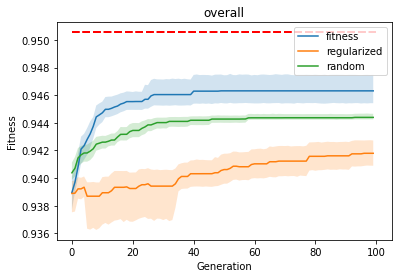

In [22]:
cut_off_beginning = 0
best_loss = 0.04944576819737756
best_acc = 1.0-best_loss
plot_mean_and_bootstrapped_ci_multiple(input_data=[np.transpose(x)[cut_off_beginning:n_iters] for k, x in fitness_results.items()], name=[k for k,x in fitness_results.items()], x_label="Generation", y_label="Fitness", compute_CI=True, maximum_possible=best_acc)

[(4, 0, -1), (2, 1, 1), (1, 0, 1), (1, 3, 0), (1, 3, 0), (0, 0, 2), (0, 2, -2)]
looping for 4 times for out edges in node 0
adding edge: 0 to 1
adding edge: 0 to 3
adding edge: 0 to 4
adding edge: 0 to 6
looping for 2 times for out edges in node 1
adding edge: 1 to 3
adding edge: 1 to 4
looping for 1 times for out edges in node 2
adding edge: 2 to 3
looping for 1 times for out edges in node 3
adding edge: 3 to 4
looping for 1 times for out edges in node 4
adding edge: 4 to 6
looping for 0 times for out edges in node 5
looping for 0 times for out edges in node 6
[(4, 0, -1), (2, 1, 1), (0, 0, 2), (1, 2, 0), (2, 3, 0), (0, 1, 2), (0, 2, -2)]
looping for 4 times for out edges in node 0
adding edge: 0 to 1
adding edge: 0 to 3
adding edge: 0 to 4
adding edge: 0 to 5
looping for 2 times for out edges in node 1
adding edge: 1 to 3
adding edge: 1 to 4
looping for 0 times for out edges in node 2
looping for 1 times for out edges in node 3
adding edge: 3 to 4
looping for 2 times for out edges in

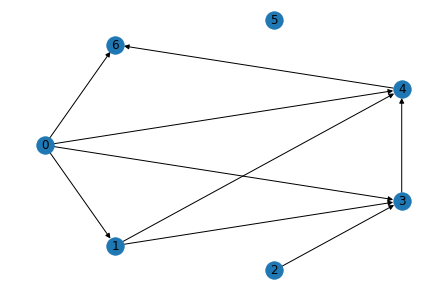

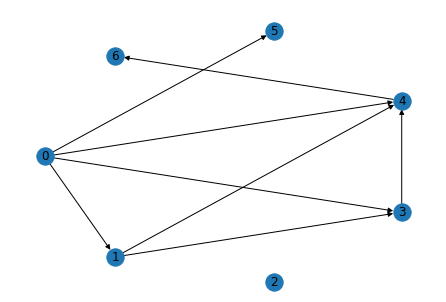

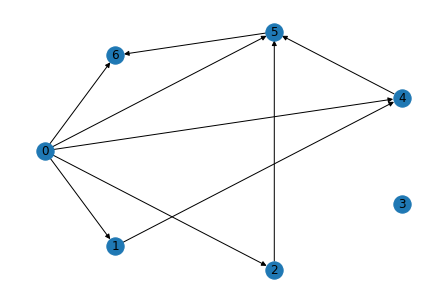

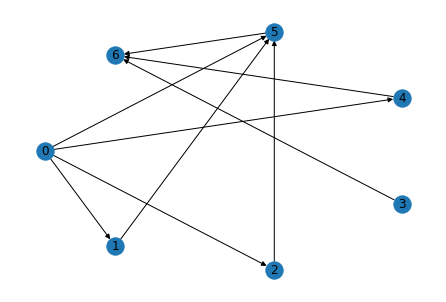

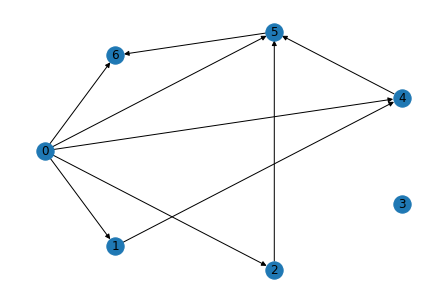

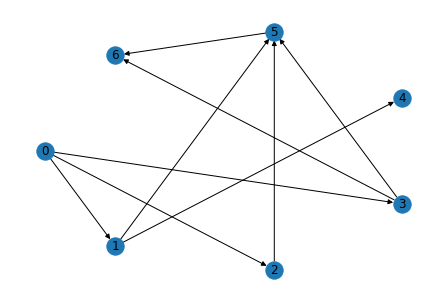

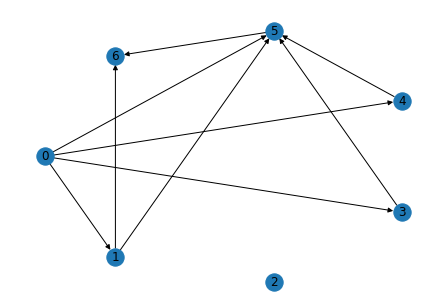

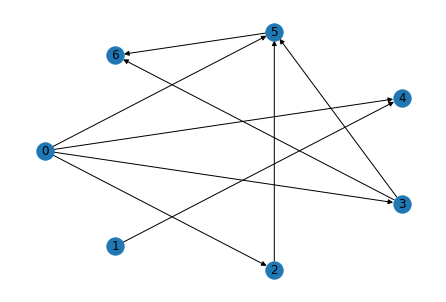

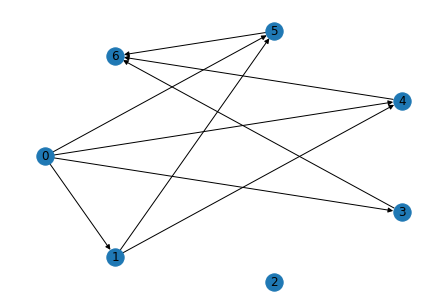

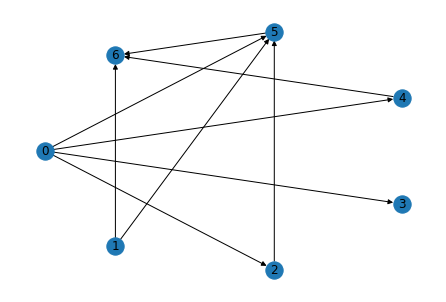

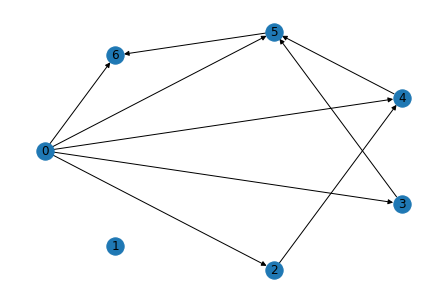

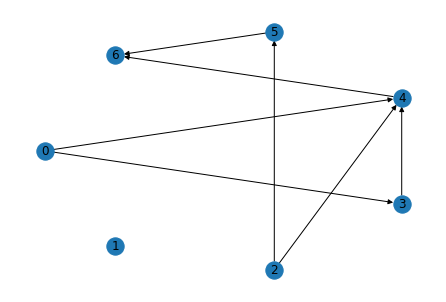

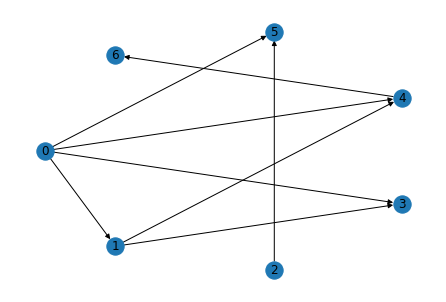

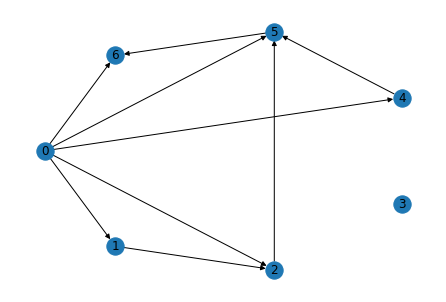

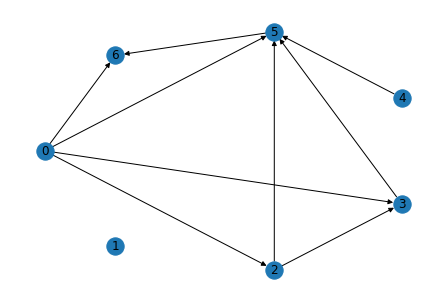

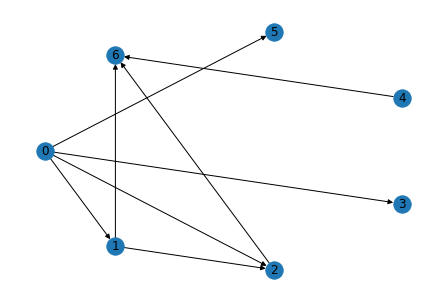

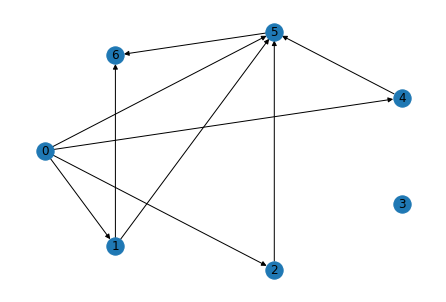

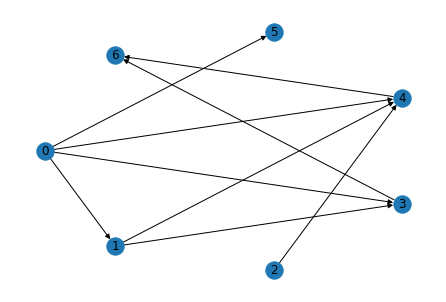

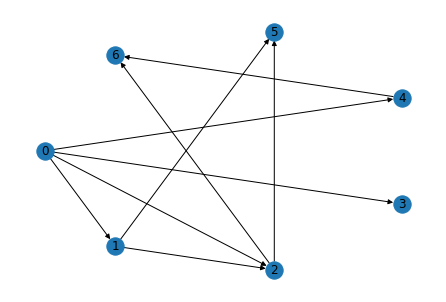

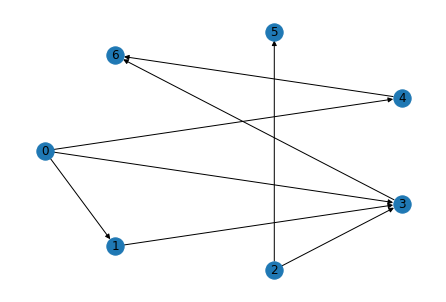

[0.0, 3.0, 2.0, 6.0, 2.0, 6.0, 4.0, 4.0, 6.0, 6.0, 2.0, 6.0, 5.0, 2.0, 2.0, 5.0, 4.0, 4.0, 6.0, 5.0, 3.0, 0.0, 3.0, 3.0, 3.0, 5.0, 3.0, 3.0, 3.0, 5.0, 3.0, 3.0, 2.0, 3.0, 3.0, 4.0, 3.0, 3.0, 5.0, 4.0, 2.0, 3.0, 0.0, 4.0, 0.0, 6.0, 4.0, 4.0, 4.0, 4.0, 0.0, 6.0, 5.0, 0.0, 2.0, 5.0, 4.0, 4.0, 4.0, 5.0, 6.0, 3.0, 4.0, 0.0, 4.0, 4.0, 2.0, 4.0, 4.0, 2.0, 4.0, 4.0, 5.0, 4.0, 6.0, 3.0, 2.0, 4.0, 4.0, 3.0, 2.0, 3.0, 0.0, 4.0, 0.0, 6.0, 4.0, 4.0, 4.0, 4.0, 0.0, 6.0, 5.0, 0.0, 2.0, 5.0, 4.0, 4.0, 4.0, 5.0, 6.0, 5.0, 6.0, 4.0, 6.0, 0.0, 2.0, 4.0, 6.0, 6.0, 6.0, 6.0, 7.0, 6.0, 6.0, 5.0, 2.0, 6.0, 4.0, 3.0, 4.0, 3.0, 4.0, 2.0, 4.0, 2.0, 0.0, 2.0, 4.0, 4.0, 4.0, 4.0, 5.0, 4.0, 4.0, 3.0, 0.0, 4.0, 4.0, 3.0, 4.0, 3.0, 4.0, 4.0, 4.0, 4.0, 2.0, 0.0, 4.0, 4.0, 4.0, 6.0, 3.0, 4.0, 6.0, 3.0, 2.0, 4.0, 4.0, 3.0, 6.0, 3.0, 4.0, 4.0, 4.0, 6.0, 4.0, 4.0, 0.0, 4.0, 4.0, 4.0, 3.0, 4.0, 6.0, 5.0, 4.0, 2.0, 4.0, 5.0, 6.0, 5.0, 4.0, 2.0, 4.0, 6.0, 4.0, 4.0, 4.0, 0.0, 4.0, 4.0, 5.0, 4.0, 6.0, 3.0, 4.0, 2.0, 4.0, 3.0,

In [23]:
# This cell explores how architectures that have different model_specs or hashes can actually be the same model overall
ops_choices = ['conv3x3-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3']
all_hashes = []
graphs = []
for config in [x[-1] for x in solution_results['fitness']]:
    matrix = np.zeros([7, 7], dtype=np.int8)
    idx = np.triu_indices(matrix.shape[0], k=1)
    for i in range(7 * (7 - 1) // 2):
        row = idx[0][i]
        col = idx[1][i]
        matrix[row, col] = config["edge_%d" % i]
    labeling = [config["op_node_%d" % i] for i in range(5)]
    labeling = ['input'] + list(labeling) + ['output']
    
    in_edges = np.sum(matrix, axis=0).tolist()
    out_edges = np.sum(matrix, axis=1).tolist()
    labeling = [-1]+[ops_choices.index(x) for x in labeling[1:-1]]+[-2]
    hashes = list(zip(out_edges, in_edges, labeling))
    in_edges = list(zip(labeling, in_edges))
    out_edges = list(zip(labeling, out_edges))
    print(hashes)
    all_hashes.append(hashes)
#     print()
#     hashes = [hashlib.md5(str(h).encode('utf-8')).hexdigest() for h in hashes]
  # Computing this up to the diameter is probably sufficient but since the
  # operation is fast, it is okay to repeat more times.
#     for _ in range(7):
#         new_hashes = []
#         for v in range(7):
#             in_neighbors = [hashes[w] for w in range(7) if matrix[w, v]]
#             out_neighbors = [hashes[w] for w in range(7) if matrix[v, w]]
#             new_hashes.append(hashlib.md5(
#           (''.join(sorted(in_neighbors)) + '|' +
#            ''.join(sorted(out_neighbors)) + '|' +
#            hashes[v]).encode('utf-8')).hexdigest())
#         hashes = new_hashes
#     fingerprint = hashlib.md5(str(sorted(hashes)).encode('utf-8')).hexdigest()
#     print(fingerprint)
#     print()

    # Going to need to actually functionally construct the graphs then use is_isomorphic across all of them to see if they are the same
    D = None
    D = nx.DiGraph()
    for n in range(len([h[2] for h in hashes])):
        D.add_node(n)
    
    # For each edge count, node pair
    count = 0
    for oe in out_edges:
        # loop for each edge coming out of this node until all of them have been added to the subsequent nodes
        print('looping for', oe[1], 'times for out edges in node', count)
        k = 0
        inner_count = 0
        j = 0
        while k < oe[1] and j < len(D.nodes())-1:
            # go to each of the subsequent nodes and connect if that node wants another in_edge
            j = count+inner_count+1
#             print(D.in_edges(j), len(D.in_edges(j)), in_edges[j][1]) 
            if (len(D.in_edges(j)) == 0 and in_edges[j][1] > 0) or (len(D.in_edges(j)) > 0 and in_edges[j][1] > len(D.in_edges(j))):
                print('adding edge:', count, 'to', j)
                D.add_edge(count, j)
                k += 1
            inner_count+=1

        count += 1
    
                
#     print([i[1] for i in in_edges])
#     print([o[1] for o in out_edges])
#     D = nx.directed_configuration_model([i[1] for i in in_edges], [o[1] for o in out_edges])
    graphs.append(D)
    
    
edit_distances = []
for g in graphs:    
    pos = nx.shell_layout(g)
    nx.draw(g, pos=pos, with_labels=True) #labels=[0,1,2,3,4,5,6])
    plt.show()
    for g2 in graphs:
        edit_distances.append(nx.graph_edit_distance(g, g2))
    
print(edit_distances)

        
# print(matrix)
# print(matrix.shape[0])
# print(np.sum(matrix, axis=0))
# print(np.sum(matrix, axis=1))
# in_edges = np.sum(matrix, axis=0).tolist()
# out_edges = np.sum(matrix, axis=1).tolist()
# labeling = [-1]+['conv3x3-bn-relu' for i in range(5)]+[-2]
# hashes = list(zip(out_edges, in_edges, labeling))
# print(hashes)

print([x[-1] for x in fitness_results['fitness']])
print([x[-1] for x in fitness_results['regularized']])

# print([x[-1] for x in solution_results['fitness']])
# print([x[-1] for x in solution_results['regularized']])

The Cells below approach genotypic diversity metrics by enumerating all possible valid architectures that are possible.

In [9]:
hyperparameter_dict = cs.get_hyperparameters_dict()
hyperparameter_list = [h for h, v in hyperparameter_dict.items()]
all_possible_edge_values = [list(v.choices) for h, v in hyperparameter_dict.items() if 0 in v.choices]
all_possible_node_op_values = [list(v.choices) for h, v in hyperparameter_dict.items() if 0 not in v.choices]

In [10]:
import itertools
valid_edge_values = []
for element in itertools.product(*all_possible_edge_values):
    e_dict = {}
    if sum(list(element))<=9 and sum(list(element))>=3:
        for e in range(len(list(element))):
            e_dict["edge_%d" % e] = element[e]
        valid_edge_values.append(e_dict)
#         print(e_dict)
    

In [11]:
valid_node_op_values = []
for element in itertools.product(*all_possible_node_op_values):
    n_dict = {}
    for n in range(len(list(element))):
        n_dict["op_node_%d" % n] = element[n] 
    valid_node_op_values.append(n_dict)
#     print(n_dict)
    
print(len(valid_edge_values)*len(valid_node_op_values))

169037604


In [ ]:
valid_configurations = []
for e in valid_edge_values:
    for o in valid_node_op_values:
        valid_configurations.append(dict(e, **o))
#         print(dict(e, **o))
print(len(valid_configurations), len(valid_edge_values)*len(valid_node_op_values))

check_validity = []
for c in valid_configurations:
    check_validity.append(train_and_eval(c))

In [ ]:
# fitness_over_time, solutions_over_time, history = evolution(
#     generations=n_iters, population_size=pop_size, tournament_size=tournament_size, evolution_type=evolution_type)
if benchmark == "nas_cifar10a" or benchmark == "nas_cifar10b":
    results = b.get_results(ignore_invalid_configs=True)
else:
    results = b.get_results()

fh = open(os.path.join(output_path, 'run_%d.json' % run_id), 'w')
json.dump(res, fh)
fh.close()